In [35]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
sns.set(context='talk',style='darkgrid', palette='mako_r')

In [2]:
data_path = ("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")
df = pd.read_csv(data_path)

In [3]:
df.shape

(31984, 21)

In [4]:
null = df.isnull().sum()
null[null>0]

ctz      30740
state     2576
city         1
dtype: int64

In [5]:
df.drop(['ctz','state'],axis=1,inplace=True)
df.dropna(inplace=True)

In [6]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,71.40,8,3.27,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,116.37,21,5.30,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,67.42,1,3.08,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,116.37,27,5.37,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,67.83,2,3.10,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [7]:
df.describe()

,division,age,official,genderdiv,overall,pace
count,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000,31983.000000
mean,1932.615858,42.406716,242.997837,8051.148579,15939.640340,9.275678
std,1715.229489,11.316488,52.301165,4754.043678,9233.117792,1.992514
min,1.000000,18.000000,80.600000,1.000000,1.000000,3.080000
25%,610.000000,33.000000,205.525000,3972.000000,7943.500000,7.850000
50%,1425.000000,42.000000,232.370000,7970.000000,15940.000000,8.870000
75%,2611.000000,50.000000,273.240000,11968.000000,23935.500000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


In [8]:
df.iloc[3189]

10k                         -
name         Haushalter, Jeff
division                  647
25k                         -
gender                      M
age                        47
official               195.82
bib                      3622
genderdiv                4815
35k                    160.48
overall                  5463
pace                     7.48
30k                         -
5k                          -
half                        -
20k                         -
country                   USA
city                  Atlanta
40k                    184.62
Name: 3189, dtype: object

In [9]:
cols_to_num = ['10k','25k','35k','30k','5k','half','20k','40k']
for col in cols_to_num:
    df[col] = df[col].str.replace('-','')
    df[col] = pd.to_numeric(df[col])
    

In [10]:
df.isnull().sum()

10k           50
name           0
division       0
25k          216
gender         0
age            0
official       0
bib            0
genderdiv      0
35k           34
overall        0
pace           0
30k           40
5k            52
half          72
20k           51
country        0
city           0
40k           39
dtype: int64

In [11]:
#I can either drop these, or fill them with 0, or the mean.
#However these options could skew the results of the clustering
#I prefer to drop them
df.dropna(inplace=True)

In [12]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,71.40,8,3.27,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,116.37,21,5.30,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,67.42,1,3.08,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,116.37,27,5.37,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,67.83,2,3.10,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [13]:
countries = df.groupby('country')['official','age','overall','genderdiv'].mean()
df['countme'] = 1
countries['parts'] = df.groupby('country')['countme'].sum()
countries.reset_index(inplace=True)
countries.head()

,country,official,age,overall,genderdiv,parts
0,ARG,207.736000,43.333333,8800.000000,4688.800000,15
1,AUS,223.861220,44.414634,12267.414634,6734.146341,123
2,AUT,251.453333,49.952381,18181.095238,9898.666667,21
3,BAH,270.550000,45.000000,23049.500000,9647.500000,2
4,BAR,256.120000,46.000000,21166.000000,8677.000000,1


Text(0.5,0,'Participants')

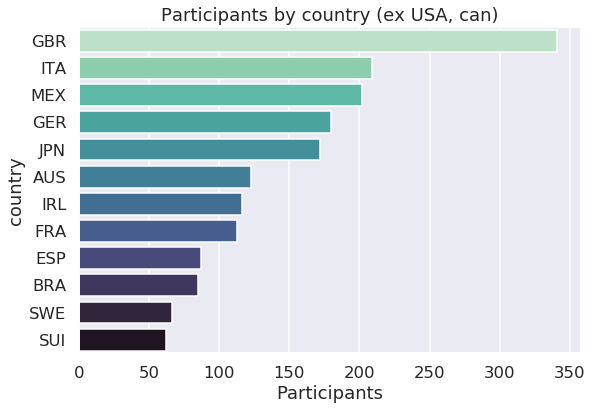

In [14]:
plt.figure(figsize=(9,6))
sns.barplot(x='parts',y='country',data=countries.sort_values(by='parts',ascending=False)[2:14],palette='mako_r')
plt.title('Participants by country (ex USA, can)')
plt.xlabel('Participants')

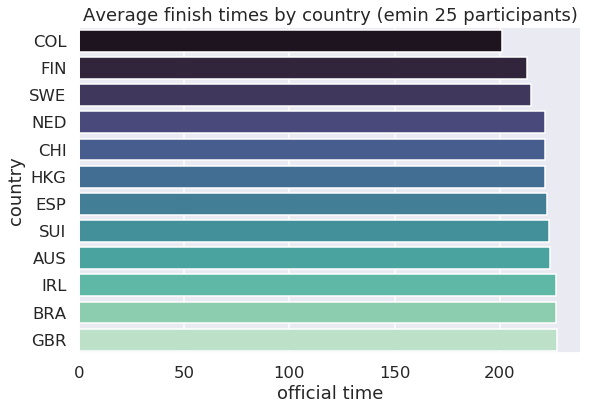

In [15]:
plt.figure(figsize=(9,6))
sns.barplot(x='official',y='country',data=countries[countries.parts > 25].sort_values(by='official')[:12],palette='mako')
plt.title('Average finish times by country (emin 25 participants)')
plt.xlabel('official time')
plt.show()

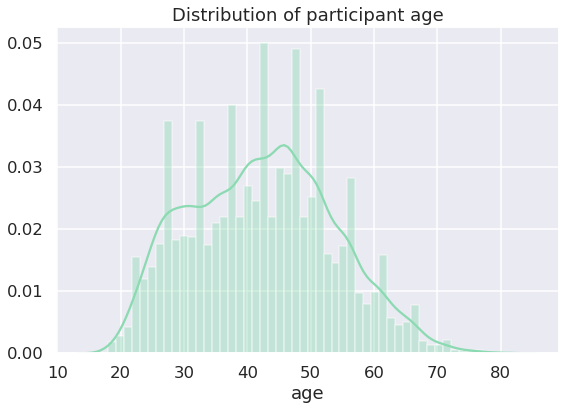

In [16]:
plt.figure(figsize=(9,6))
sns.distplot(df.age)
plt.title('Distribution of participant age')
plt.show()

Text(0.5,1,'Distribution of countries by average age of participants')

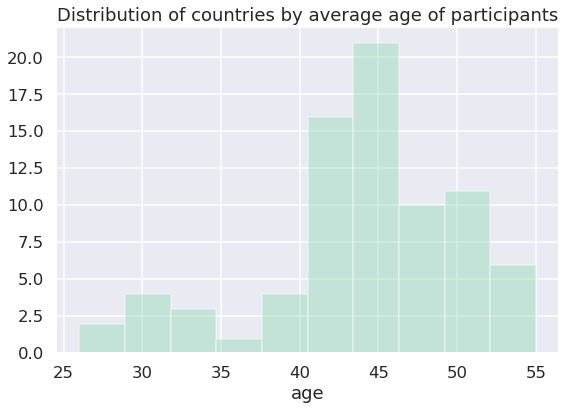

In [17]:
plt.figure(figsize=(9,6))
sns.distplot(countries['age'],kde=False)
plt.title("Distribution of countries by average age of participants")

In [18]:
df.gender = np.where(df.gender == 'M',1,0)

In [19]:
df.country = df.country.astype('category')
df.country = df.country.cat.codes

In [29]:
data = df.drop(['name','bib','city','countme'],axis=1)

In [42]:
data_norm = normalize(data)


In [43]:
#split the data
X1, X2, X3, X4 = np.array_split(data_norm, 4)
Xs = [X1,X2,X3,X4]


In [44]:
#all data
clusters = [2,4,9,16,25,36,49]
for i in clusters:
    print("Number of defined clusters: {}".format(i))
    for j in Xs:
        model = KMeans(n_clusters=i, random_state=None).fit(j)
        labels = model.labels_
        print(metrics.silhouette_score(j, labels, metric='euclidean'))

Number of defined clusters: 2
0.6344528035587395
0.6763265565857736
0.547816224513957
0.4899506175113295
Number of defined clusters: 4
0.6067538845849694
0.6119699623457273
0.628262030180075
0.7097021832469115
Number of defined clusters: 9
0.517903649557142
0.45741707783713254
0.494251975798686
0.6916870898821207
Number of defined clusters: 16
0.448445541345246
0.46096787472804174
0.4938951093796292
0.6073933281807807
Number of defined clusters: 25
0.45944156950952436
0.4658673910024422
0.477353064737719
0.5760537134504797
Number of defined clusters: 36
0.45247231930749504
0.4727820658478203
0.4818737164868562
0.5490327748669995
Number of defined clusters: 49
0.45023637164919533
0.48153345248521157
0.49309021663130537
0.5137618777923647


From the K-means clusters, i would choose 4 clusters. because the while the coefficients arent the most consistent, the scores are the closest to 1, indicating dense clusters.

In [45]:
#all data
for i in Xs:    
    bandwidth = estimate_bandwidth(i, quantile=0.2, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(i)    
    labels = ms.labels_ # Extract cluster assignments for each data point.   
    cluster_centers = ms.cluster_centers_  # Coordinates of the cluster centers.    
    n_clusters_ = len(np.unique(labels)) # Count our clusters.
    print("Number of estimated clusters: {}".format(n_clusters_)) 
    print(metrics.silhouette_score(i, labels, metric='euclidean'))

Number of estimated clusters: 5
0.5940614469131958
Number of estimated clusters: 5
0.41433070109616077
Number of estimated clusters: 4
0.5974116909302417
Number of estimated clusters: 5
0.7258355084629201


I chose 4 clusters before, but I would investigate further and consider 5.

In [34]:
clusters = [4,9,16]
for i in clusters:
    print("Number of defined clusters: {}".format(i))
    for j in Xs:
        sc = SpectralClustering(n_clusters=i)
        sc.fit(j)
        labels = sc.labels_
        print(metrics.silhouette_score(j, labels, metric='euclidean'))

Number of defined clusters: 4
0.49874923355602996
0.49429759462325146
0.49181825804452217
0.4842844079345178
Number of defined clusters: 9
0.47528597924982025
0.44185130037153614
0.44932592716943454
0.4180086403371709
Number of defined clusters: 16
0.31976198300455955
0.286363370727083
0.2974871601869288
0.30593498979446004


In [38]:
for j in Xs:
    af = AffinityPropagation(damping=.9).fit(j)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters2_ = len(cluster_centers_indices)
    labels2 = af.labels_
    print('Estimated number of clusters: {}'.format(n_clusters2_))
    print(metrics.silhouette_score(j, labels2, metric='euclidean'))

Estimated number of clusters: 43
0.5003811810138581
Estimated number of clusters: 43
0.5110883809719976
Estimated number of clusters: 39
0.5186826184117475
Estimated number of clusters: 43
0.5122451011131333


Overall looks like 5 clusters will be chosen for higher scores and somewhat better consistency
Ill use the mean shift

In [102]:
bandwidth = estimate_bandwidth(data_norm, quantile=0.2, n_samples=2500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data_norm)    
labels = ms.labels_ # Extract cluster assignments for each data point.   
cluster_centers = ms.cluster_centers_  # Coordinates of the cluster centers.    
n_clusters_ = len(np.unique(labels)) # Count our clusters.



In [103]:
labels.shape

(31648,)

In [104]:
data['label'] = labels


,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,country,40k,labels,label
0,17.37,8,47.67,1,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,41,80.43,2,2
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,42,132.10,2,2
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,59,76.10,2,2
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,26,132.95,2,2
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,41,76.72,2,2
5,32.58,4,82.45,0,29,140.68,4,116.37,28,5.37,99.33,16.22,69.47,65.83,42,132.95,2,2
6,17.65,4,47.67,1,28,84.65,4,70.23,4,3.23,58.60,8.38,39.72,37.65,63,79.83,2,2
7,30.48,5,76.95,1,29,129.83,5,107.47,5,4.97,92.52,15.17,64.85,61.62,26,122.80,2,2
8,17.12,3,46.37,1,43,81.23,3,67.83,3,3.10,57.03,8.00,38.60,36.60,41,76.70,2,2
9,30.48,20,77.68,1,31,137.83,20,112.27,20,5.27,94.78,15.15,65.23,61.78,74,129.83,2,2


In [149]:
plot_df = data.groupby('label')['age','official','gender'].mean().sort_values(by='age',ascending=False).reset_index()


In [150]:
plot_df.head()

,label,age,official,gender
0,0,43.791031,250.390430,0.491902
1,3,35.353333,159.077800,0.956667
2,1,32.059277,185.875012,1.000000
3,2,31.194737,134.796526,0.821053


Text(0.5,1,'Average Age by Cluster')

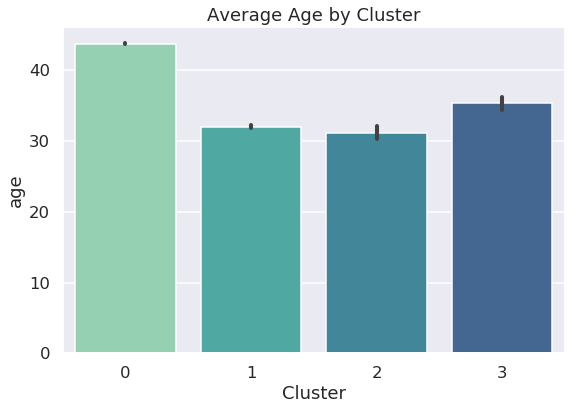

In [121]:
plt.figure(figsize=(9,6))
sns.barplot(x='label',y='age',data=data)
plt.xlabel('Cluster')
plt.title('Average Age by Cluster')

Text(0.5,1,'Average official by Cluster')

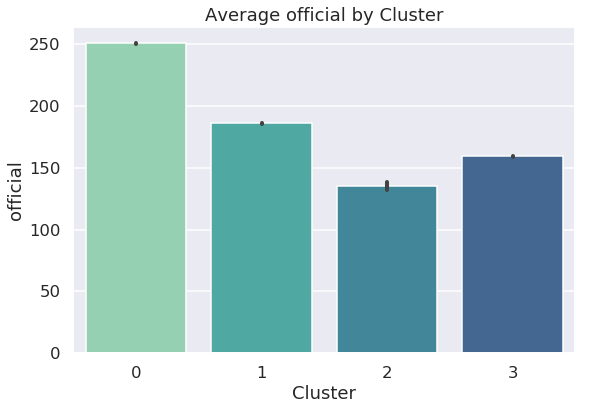

In [123]:
plt.figure(figsize=(9,6))
sns.barplot(x='label',y='official',data=data)
plt.xlabel('Cluster')
plt.title('Average official by Cluster')

<Figure size 1080x648 with 0 Axes>

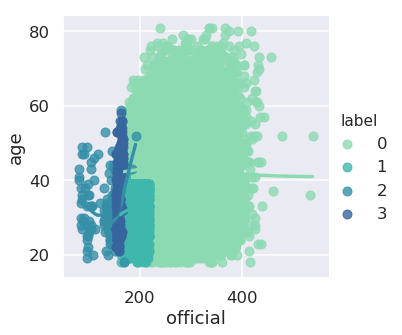

In [136]:
plt.figure(figsize=(15,9))
sns.lmplot(x='official',y='age',hue='label',data=data, lowess=True)
plt.show()

In [178]:
model = KMeans(n_clusters=5, random_state=None).fit(data_norm)
labels = model.labels_
data['labelk5'] = labels
data.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,...,5k,half,20k,country,40k,labels,label,labelk,labelk4,labelk5
0,17.37,8,47.67,1,47,85.25,8,71.40,8,3.27,...,8.02,39.72,37.65,41,80.43,2,2,3,1,2
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,...,16.22,69.47,65.83,42,132.10,2,2,3,1,2
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,...,7.75,38.03,36.10,59,76.10,2,2,3,1,2
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,...,16.20,69.47,65.83,26,132.95,2,2,3,1,2
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,...,8.02,38.60,36.58,41,76.72,2,2,3,1,2


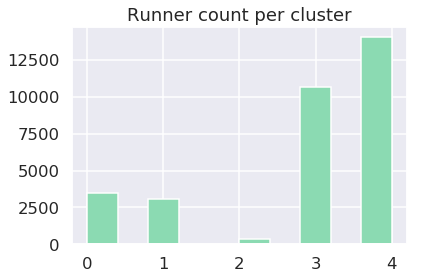

In [179]:
data.labelk5.hist()
plt.title('Runner count per cluster')
plt.show()

In [181]:
kmeanpdf = data.groupby('labelk5')['age','official','40k','25k','10k','genderdiv','gender'].mean()

In [182]:
kmeanpdf

,age,official,40k,25k,10k,genderdiv,gender
labelk5,,,,,,,
0,35.464069,205.403128,194.209322,117.829333,46.611556,1771.167677,0.000000
1,31.850129,183.550749,173.015397,103.691654,41.153763,2924.485465,1.000000
2,32.084881,145.745889,137.682546,83.963077,33.034058,121.493369,0.896552
3,41.194747,269.624382,254.653152,148.909059,56.903834,8873.611820,0.000000
4,47.592028,245.422606,231.079831,133.754512,51.671717,10209.960142,1.000000


This clustering is interesting. The are 4 four clusters that descriminate by age AND gender! However the cluster that is index 3, is a unique cluster found by multiple algorithms, these are the early finishers.

So the clustering, found older women, older men, younger men, younger woman, and the top finishers. Lets see what this looks like.

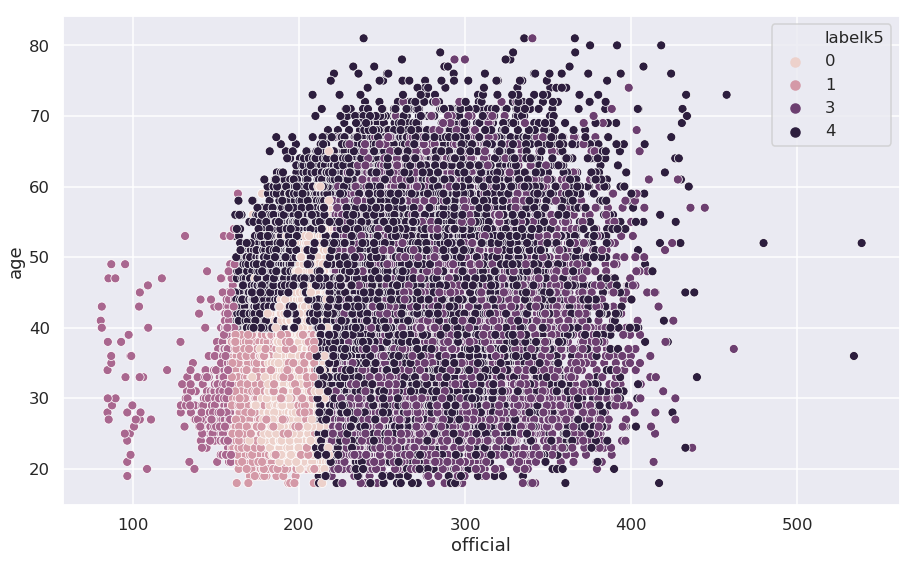

In [183]:
plt.figure(figsize=(15,9))
sns.scatterplot(x='official',y='age',hue='labelk5',data=data)
plt.show()

As you can see, cluster 0 represents younger women, 1 is younger men, 2 are the top finishers 3 is older women and 4 is older men. 

I started the project by cleaning exploring and cleaning up the data. Then,
I tried a few different clustering algorithms to create clusters in the data. For K means, the 4 cluster
configuration looked the most promising (based on scores), however the means shift suggested 5 clusters for 3 of the 4 batches. The spectral clustering and affinity propagation methods did not appear to helpful, however further investigation with those methods may reveal other insights about the data.
    At the start,I chose mean-shift because i figured it would give 5 clusters, however, it gave 4, over and over again. I did visualize the results a but was not really satisfied. At that point I switched to K-means and declared 5 clusters, the results were better. As I pointed out above, the clusters descriminate well for gender, and then for performance.

